# Importing Libraries and Data

In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import re
import string

In [4]:
#concatenating the two datasets
#news1 = pd.read_csv('news_summary/news_summary.csv', encoding='latin-1')
#news2 = pd.read_csv('news_summary/news_summary_more.csv', encoding='latin-1')
#data = pd.concat([news1, news2], axis=0).reset_index(drop=True)
#data = pd.read_csv('cnn_dailymail/train.csv', encoding='latin-1')
data = pd.read_csv('articles/Articles.csv', encoding='latin-1')

# Preprocessing

In [5]:
#removinng and expanding the contractions
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
"didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
"he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
"I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
"i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
"mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
"oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
"she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
"should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
"this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
"we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
"where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
"why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"}

In [6]:
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from sklearn.model_selection import train_test_split

In [7]:
StopWords = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower() #converting input to lowercase
    text = re.sub(r'\([^)]*\)', '', text) #Removing punctuations and special characters.
    text = re.sub('"','', text) #Removing double quotes.
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #Replacing contractions.   
    text = re.sub(r"'s\b","",text) #Eliminating apostrophe.
    text = re.sub("[^a-zA-Z]", " ", text) #Removing non-alphabetical characters
    text = ' '.join([word for word in text.split() if word not in StopWords]) #Removing stopwords.
    text = ' '.join([word for word in text.split() if len(word) >= 3]) #Removing very short words
    return text



In [8]:
#Apply preprocessing to both text and summary
cleaned_text = []
cleaned_summary = []
for text in data['Article']:
    cleaned_text.append(preprocess(text))
for summary in data['Heading']:
    cleaned_summary.append(preprocess(summary))
cleaned_data = pd.DataFrame()
cleaned_data['article'] = cleaned_text
cleaned_data['headline'] = cleaned_summary

#Replacing empty string summaries with nan values and then dropping those datapoints.
cleaned_data['headline'].replace('', np.nan, inplace=True)
cleaned_data.dropna(axis=0, inplace=True)



In [9]:
#Adding START and END tokens for indication
cleaned_data['headline'] = cleaned_data['headline'].apply(lambda x: '<START>' + ' '+ x + ' '+ '<END>')
for i in range(10):
    print('Article: ', cleaned_data['article'][i])
    print('Headline:', cleaned_data['headline'][i])
    print('\n')

Article:  karachi sindh government decided bring public transport fares per cent due massive reduction petroleum product prices federal government geo news reported sources said reduction fares applicable public transport rickshaw taxi means traveling meanwhile karachi transport ittehad refused abide government decision kti president irshad bukhari said commuters charged lowest fares karachi compare parts country adding vehicles run compressed natural gas bukhari said karachi transporters cut fares decrease cng prices made
Headline: <START> sindh govt decides cut public transport fares kti rej <END>


Article:  hong kong asian markets started upswing limited trading friday mainland chinese stocks surging hong kong speculation beijing may ease monetary policy boost slowing growth hong kong rose percent closing points higher seoul closed percent rising points sydney gained percent points close singapore edged percent gaining points markets mainland china japan taiwan new zealand philippi

In [10]:
#Get max length of texts and summaries.
news_length = max([len(text.split()) for text in cleaned_data['article']])
headline_length = max([len(text.split()) for text in cleaned_data['headline']])
print(news_length, headline_length)

1778 14


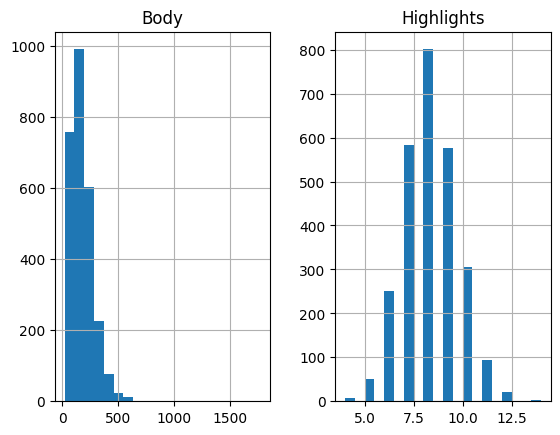

In [11]:
import matplotlib.pyplot as plt

text_word_count = []
headline_word_count = []

for i in cleaned_data['article']:
      text_word_count.append(len(i.split()))

for i in cleaned_data['headline']:
      headline_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':headline_word_count})
length_df.hist(bins = 20)
plt.show()

# III. Tokenization and Data Split

In [12]:
import keras
from keras import backend as K
from keras.layers import Layer
from keras.layers import Concatenate
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, TimeDistributed, LSTM, Embedding, Input
from keras import Model

In [13]:
#splitting data into 80-20 ratio as train and test data
X_train, X_test, y_train, y_test = train_test_split(cleaned_data['article'], cleaned_data['headline'], test_size=0.2, random_state=0)

#Keras tokenizer for news text.
tokenizer_news = Tokenizer()
tokenizer_news.fit_on_texts(list(X_train))
x_train_seq = tokenizer_news.texts_to_sequences(X_train)
x_test_seq = tokenizer_news.texts_to_sequences(X_test)
#padding short texts with 0s.
x_train_pad = pad_sequences(x_train_seq, maxlen=news_length, padding='post') 
x_test_pad = pad_sequences(x_test_seq, maxlen=news_length, padding='post')
#Vocab size of texts.
news_vocab = len(tokenizer_news.word_index) + 1

#Keras Tokenizer for summaries.
tokenizer_headline = Tokenizer()
tokenizer_headline.fit_on_texts(list(y_train))
y_train_seq = tokenizer_headline.texts_to_sequences(y_train)
y_test_seq = tokenizer_headline.texts_to_sequences(y_test)
y_train_pad = pad_sequences(y_train_seq, maxlen=headline_length, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=headline_length, padding='post')
#Vocab size of summaries.
headline_vocab = len(tokenizer_headline.word_index) + 1

# **[Attention Layer Reference](https://github.com/jananiarunachalam/Research-Paper-Summarization/blob/master/Abstractive_Summarization.ipynb)**

In [14]:
#Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf)
class AttentionLayer(Layer):
    def __init__(self, **kwargs): #-----> to inherit the layer class from keras
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):#------> function to create trainable weights w1,w2,w3
        assert isinstance(input_shape, list)
        self.W1 = self.add_weight(name='W1',shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),initializer='uniform',trainable=True)
        self.W2 = self.add_weight(name='w2',shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),initializer='uniform',trainable=True)
        self.W3 = self.add_weight(name='w3',shape=tf.TensorShape((input_shape[0][2], 1)),initializer='uniform',trainable=True)
        super(AttentionLayer, self).build(input_shape)  

    def call(self, inputs, verbose=False):
    
        #inputs for this function: [encoder_output_sequence, decoder_output_sequence]
        #outputs from this function : energy_i which is energy at step i
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):#----->function for computing energy for a single decoder state
            
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            #shaping tensors
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            #Computing S.W1 ------> dot product of encoder output with trainable weight w1
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W1_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W1), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W1_dot_s.shape)

            #Computing h.w2 -------> dot product of decoder with w2 weights
            W2_dot_h = K.expand_dims(K.dot(inputs, self.W2), 1)  
            if verbose:
                print('W2.h>',W2_dot_h.shape)

            #tanh(S.W1a + hj.W2a)----> concatenation based attention score calculation\
            # tanh activation will squash the values to -1 to 1 range
            reshaped_W1s_plus_W2h = K.tanh(K.reshape(W1_dot_s + W2_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_W1s_plus_W2h.shape)

            #softmax(w3.tanh(S.W1 + hj.w2)) -----> probability distribution for energy
            # calculating the attention energy at each step and dot producting with w3
            energy_i = K.reshape(K.dot(reshaped_W1s_plus_W2h, self.W3), (-1, en_seq_len))
            energy_i = K.softmax(energy_i)

            if verbose:
                print('energy at i>', energy_i.shape)

            return energy_i, [energy_i]

        def context_step(inputs, states):#------> function to calculate context vector at each stage
            #this function outputs the context vector at each stage
            context_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return context_i, [context_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])
            fake_state = K.expand_dims(fake_state)
            fake_state = K.tile(fake_state, [1, hidden_size])
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1]) 

        #Computing energy outputs
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],)

        #Computing context vectors 
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],)

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        #reshaping Outputs produced by the layer
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

 # IV. Training Model (Encoder-Decoder Architecture)

In [15]:
K.clear_session()

embedding_dim = 300 #Size of word embeddings. 50
latent_dim = 500 #Number of neurons in LSTM layer. 150

#Embedding Layer
e_input = Input(shape=(news_length, ))
e_emb = Embedding(news_vocab, embedding_dim, trainable=True)(e_input) 

#Three LSTM layers ----> encoder.
e_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = e_lstm1(e_emb)
e_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_2, a_2, c_2 = e_lstm2(y_1)
e_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc, c_enc = e_lstm3(y_2)

#Single LSTM layer ----> decoder 
d_input = Input(shape=(None,))
d_emb = Embedding(headline_vocab, embedding_dim, trainable=True)(d_input)
d_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = d_lstm(d_emb, initial_state=[a_enc, c_enc]) #Final output states of encoder last layer are fed into decoder.

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_output, decoder_output]) 

#concatenating decoder input to attention layer output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])
#dense time distributed layer with softw=max fucntion for predicting the next word
decoder_dense = TimeDistributed(Dense(headline_vocab, activation='softmax'))
decoder_output = decoder_dense(decoder_concat_input)

#creating model
model = Model([e_input, d_input], decoder_output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1778)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1778, 300)    6857700     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1778, 500),  1602000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [16]:
#Training the model with Early Stopping callback on val_loss.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history=model.fit([x_train_pad,y_train_pad[:,:-1]], y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,epochs=3,callbacks=[callback],batch_size=32, validation_data=([x_test_pad,y_test_pad[:,:-1]], y_test_pad.reshape(y_test_pad.shape[0],y_test_pad.shape[1], 1)[:,1:]))

Epoch 1/3
 1/68 [..............................] - ETA: 11:41:22 - loss: 8.2736

# V. Inference Stage: Making Predictions!

In [ ]:
#Encoder inference model with trained inputs and outputs.
encoder_model = Model(inputs=e_input, outputs=[encoder_output, a_enc, c_enc])

#Initialising state vectors for decoder.
decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(news_length, latent_dim))

#Decoder inference model
decoder_out, decoder_a, decoder_c = d_lstm(d_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat)
decoder_model = Model([d_input]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_a, decoder_c])

In [ ]:
#Function to generate output summaries.
def decoded_sequence(input_seq):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_seq) #Collecting output from encoder inference model.
    #Initialise input to decoder neuron with START token. Thereafter output token predicted by each neuron will be used as input for the subsequent.
    #Single elt matrix used for maintaining dimensions.
    next_input = np.zeros((1,1))
    next_input[0,0] = tokenizer_headline.word_index['start']
    output_seq = ''
    #Stopping condition to terminate loop when one summary is generated.
    stop = False
    while not stop:
        #Output from decoder inference model, with output states of encoder used for initialisation.
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        #Get index of output token from y(t) of decoder.
        output_idx = np.argmax(decoded_out[0, -1, :])
        #If output index corresponds to END token, summary is terminated without of course adding the END token itself.
        if output_idx == tokenizer_headline.word_index['end']: 
            stop = True
        elif output_idx>0 and output_idx != tokenizer_headline.word_index['start'] :
            output_token = tokenizer_headline.index_word[output_idx] #Generate the token from index.
            output_seq = output_seq + ' ' + output_token #Append to summary
        
        #Pass the current output index as input to next neuron.
        next_input[0,0] = output_idx
        #Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_seq        

In [ ]:
#Print predicted summmaries and actual summaries for 60 texts. 

predicted = []
for i in range(20):
    print('Information:', X_test.iloc[i])
    print('Actual Headline:', y_test.iloc[i])
    print('Predicted Headline:', decoded_sequence(x_test_pad[i].reshape(1, news_length)))
    predicted.append(decoded_sequence(x_test_pad[i].reshape(1, news_length)).split())

Information: qualcomm monday announced chinese court order banning import sale apple iphone iphone models china due software patent violations court found apple violated two qualcomm software patents around resizing photographs managing applications touchscreen apple however said iphones remain sale china
Actual Headline: <START> qualcomm wins import ban apple iphones china <END>
1/1 [==============================] - 0s 26ms/step
Predicted Headline:  india india india india
1/1 [==============================] - 0s 25ms/step
Information: congress appointed year old amit chavda new chief gujarat unit replacing year old bharatsinh solanki held post since december comes days congress president rahul gandhi said younger generations come forward take party leadership inspired gandhi words year old shantaram naik resigned goa congress chief
Actual Headline: <START> congress appoints old amit chavda new gujarat head <END>
1/1 [==============================] - 0s 25ms/step
Predicted Headline

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'right')
df = pd.DataFrame(columns=['Information', 'Actual Headline', 'Predicted Headline'])

for i in range(10):
    information = X_test.iloc[i]
    actual_headline = y_test.iloc[i]
    predicted_headline = decoded_sequence(x_test_pad[i].reshape(1, news_length))
    predicted.append(predicted_headline.split())

    row = {'Information': information, 'Actual Headline': actual_headline, 'Predicted Headline': predicted_headline}
    #df = df.append(row, ignore_index=True)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

display(df)


1/1 [==============================] - 0s 29ms/step


,Information,Actual Headline,Predicted Headline
0,qualcomm monday announced chinese court order banning import sale apple iphone iphone models china due software patent violations court found apple violated two qualcomm software patents around resizing photographs managing applications touchscreen apple however said iphones remain sale china,<START> qualcomm wins import ban apple iphones china <END>,india india india india
1,congress appointed year old amit chavda new chief gujarat unit replacing year old bharatsinh solanki held post since december comes days congress president rahul gandhi said younger generations come forward take party leadership inspired gandhi words year old shantaram naik resigned goa congress chief,<START> congress appoints old amit chavda new gujarat head <END>,india india india india
2,male nurse employed delhi institute liver biliary sciences booked allegedly stealing government hospital stents selling private hospitals kerala hospital provided stents subsidised rate man associates allegedly helped fabricate false documents hide tracks,<START> nurse sells stents worth stolen hospital <END>,india india india india
3,finance minister arun jaitley announced government develop scheme assign every major small enterprise india unique presenting budget said scheme along lines aadhaar provided identity every indian eased delivery public services,<START> govt announces aadhaar like unique businesses <END>,india india india india
4,international organization migration slammed social media giants like facebook failing tackle human trafficking platform smugglers often use facebook reach migrants false promises jobs europe iom spokesperson leonard doyle said traffickers use whatsapp send videos tortured migrants families extortion added,<START> slams facebook failing tackle human trafficking <END>,india india india india
5,ahead budget session parliamentary affairs minister ananth kumar sunday said government everything possible get triple talaq bill passed parliament bill seeks criminalise practise instant triple talaq passed lok sabha winter session got stalled rajya sabha,<START> everything get triple talaq bill passed govt <END>,india india india india
6,university tokyo scientists recently revealed created world strongest indoor magnetic field revealed deliberately blew equipment create record measuring tesla field strength times higher generated magnets mri machines million times stronger earth magnetic field,<START> scientists blew equipment create strongest magnetic field <END>,india india india india
7,mosque kerala hosted parents around candidates arrived state give neet medical entrance exam apart mosque could also accommodate people nearby houses shops well mosque officials said mosque offered shelter food parents accompanying candidates last year well,<START> kerala mosque hosts parents neet candidates <END>,india india india india
8,levi strauss sued louis vuitton maker lvmh unit kenzo trademark infringement kenzo allegedly used levi federally protected tab array garments including new clothing line featuring singer britney spears levi said put distinctive tabs bearing name attached garments pockets since sight identification products,<START> levi sues louis vuitton maker unit trademark breach <END>,india india india india
9,kannada actor politician upendra karnataka pragnyavantha janatha paksha unveiled green yellow auto rickshaw party symbol auto signifies running aim government chosen people support run without problems said unveiling symbol party launched earlier year,<START> kannada actor upendra unveils auto rickshaw party symbol <END>,india india india india


# Evaluation metrics

In [ ]:
#creating reference list
summaries = list(y_test)
references = []
for summ in summaries:
    ref = summ.split()
    ref.remove('<START>')
    ref.remove('<END>')
    references.append(ref)

In [ ]:
refs = []
smooth = SmoothingFunction().method4
for i in range(10):
    refs.append(references[i])
    print(refs, predicted[i])
    print(sentence_bleu(refs, predicted[i], weights=(0.25,0.25,0.25,0.25)))#BLEU evaluation
    refs.remove(references[i])

[['qualcomm', 'wins', 'import', 'ban', 'apple', 'iphones', 'china']] ['india', 'india', 'india', 'india']
0
[['congress', 'appoints', 'old', 'amit', 'chavda', 'new', 'gujarat', 'head']] ['india', 'india', 'india', 'india']
0
[['nurse', 'sells', 'stents', 'worth', 'stolen', 'hospital']] ['india', 'india', 'india', 'india']
0
[['govt', 'announces', 'aadhaar', 'like', 'unique', 'businesses']] ['india', 'india', 'india', 'india']
0
[['slams', 'facebook', 'failing', 'tackle', 'human', 'trafficking']] ['india', 'india', 'india', 'india']
0
[['everything', 'get', 'triple', 'talaq', 'bill', 'passed', 'govt']] ['india', 'india', 'india', 'india']
0
[['scientists', 'blew', 'equipment', 'create', 'strongest', 'magnetic', 'field']] ['india', 'india', 'india', 'india']
0
[['kerala', 'mosque', 'hosts', 'parents', 'neet', 'candidates']] ['india', 'india', 'india', 'india']
0
[['levi', 'sues', 'louis', 'vuitton', 'maker', 'unit', 'trademark', 'breach']] ['india', 'india', 'india', 'india']
0
[['kannad

In [ ]:
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(columns=['Actual Headline','Predicted Headline', 'BLEU Score'])
refs = []
smooth = SmoothingFunction().method4
for i in range(10):
    refs.append(references[i])
    predicted_headline = predicted[i]
    bleu_score = sentence_bleu(refs, predicted_headline, weights=(0.25,0.25,0.25,0.25))

    row = {'Actual Headline':refs,'Predicted Headline': predicted[i], 'BLEU Score': sentence_bleu(refs, predicted[i], weights=(0.25,0.25,0.25,0.25))}
    #df = df.append(row, ignore_index=True)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    refs = []  # reset refs to an empty list for the next iteration

display(df.sort_values(by='BLEU Score', ascending=False))



,Actual Headline,Predicted Headline,BLEU Score
0,"[[qualcomm, wins, import, ban, apple, iphones, china]]","[india, india, india, india]",0
1,"[[congress, appoints, old, amit, chavda, new, gujarat, head]]","[india, india, india, india]",0
2,"[[nurse, sells, stents, worth, stolen, hospital]]","[india, india, india, india]",0
3,"[[govt, announces, aadhaar, like, unique, businesses]]","[india, india, india, india]",0
4,"[[slams, facebook, failing, tackle, human, trafficking]]","[india, india, india, india]",0
5,"[[everything, get, triple, talaq, bill, passed, govt]]","[india, india, india, india]",0
6,"[[scientists, blew, equipment, create, strongest, magnetic, field]]","[india, india, india, india]",0
7,"[[kerala, mosque, hosts, parents, neet, candidates]]","[india, india, india, india]",0
8,"[[levi, sues, louis, vuitton, maker, unit, trademark, breach]]","[india, india, india, india]",0
9,"[[kannada, actor, upendra, unveils, auto, rickshaw, party, symbol]]","[india, india, india, india]",0
